# Neural Network from Scratch

Constructing fully connected neural network from scratch, for myself to learn and for visualization purposes.

### Libraries used...
- Numpy
- Pandas
- Scipy
- Matplotlib

### Dataset
FashionMNIST dataset, which is MNIST dataset but fashion version from Zoland magazine, was used for this project.

- [fashionMNIST](https://github.com/zalandoresearch/fashion-mnist)

![fashionMNIST](data-original.png)


## In this notebook, we'll go over..

1. create functions for Neural Net and other utility
2. import the data, and take a look at them
3. set up and train the model
4. evaluate the model
5. plot cost & accuracy graph and confusion matrix

## 1. As a first step, we'll create functions for neural net and optimization...
- Forward & Backpropagation
- cost function & gradient calculation
- activation funciton

In [31]:
# Import libraries

%matplotlib inline
import scipy.io
import pandas as pd # library to manage data
from scipy.optimize import minimize # optimizer for training NN
from scipy import special as sp
import numpy as np # matrices calculation
import matplotlib.pyplot as plt # graphing
from sklearn.metrics import confusion_matrix # for confusion matrix for Neural Net

# and some scripts for data import and house keepin
import fashion_data_import as fin
import time

## Sigmoid and its gradient

def sigmoid(z):
    '''
    returns sigmoid function value, by using scipy.special.expit
    It takes care of runtime overflow error
    '''
    return sp.expit(z)

def sigmoidGradient(z):
    gz = sigmoid(z)
    return gz*(1-gz)


In [2]:
## Now cost function, which returns 
# cost and gradient

def CostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lam):
    '''
    performs Feedforward, backprop and return the cost in the variable J.
    also stores cost of each iteration in j_hist list
    '''
    ### reshape nn_params back into the theta1 and 2

    theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                                 (hidden_layer_size, input_layer_size + 1), order='F')
    theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                                 (num_labels, hidden_layer_size + 1), order='F')

    m = X.shape[0]
    ### initial values, to be returned correctly
    J = 0

    theta1_grad = np.zeros((theta1.shape))
    theta2_grad = np.zeros((theta2.shape))

    ## feedforwarding, input to hidden
    z2 = X.dot(theta1.T) #(60000x50) 
    a2 = sigmoid(z2) # same shape
    a2 = np.c_[np.ones((m, 1)), a2] # adding bias term

    ## feedforward, hidden to output
    z3 = a2.dot(theta2.T) #(60000x10)
    a3 = sigmoid(z3)
    
    # prediction for accuracy recording
    p = (a3.argmax(axis=1)).reshape(m, 1)
    acc = (p==y).astype(float).mean()*100

    ## converting y label vector into 1/0 matrix of (60000x10), 1 at the index of the num

    Y = np.zeros(a3.shape)
    for i in range(y.size):
        Y[i, y[i]]=1   # MNIST dataset
    

    ## calculating the cost, without regularization, vectorized :)
    j = (1/m)*np.sum((-Y*np.log(a3)-(1-Y)*np.log(1-a3)))
    
    ## regularization
    regularization = (lam/(2*m))*(np.sum(theta1[:, 1:]**2) + np.sum(theta2[:, 1:]**2))

    ## cost with regularization
    J = j + regularization

    ##### backpropagation ##########

    ## initializing param
    D2 = np.zeros((num_labels, hidden_layer_size+1))
    D1 = np.zeros((hidden_layer_size+1, input_layer_size+1))

    # Calculating derivative of each layers
    d3 = a3-Y #(6000x10)
    d2 = d3.dot(theta2)*a2*(1-a2) 

    D2 += d3.T.dot(a2) #(10x51)
    D1 += d2.T.dot(X) #(51x785)
    
    # now calculating the gradients for each weights
    theta1_grad[:, 1:] = (1/m)*D1[1:,1:] + (lam/m)*theta1[:,1:] #(50x784)
    theta1_grad[:, 0] = (1/m)*D1[1:,0]  #(50x1)

    theta2_grad[:, 1:] = (1/m)*D2[:,1:] + (lam/m)*theta2[:,1:] #(10x50)
    theta2_grad[:, 0] = (1/m)*D2[:,0]  #(10x1)

    grad = np.concatenate((theta1_grad.reshape(theta1_grad.size, order='F'), theta2_grad.reshape(theta2_grad.size, order='F')))

    # records cost and accuracy as history
    j_hist.append(J)
    test_acc.append(acc)

    return [J, grad]

In [3]:
## Predict function to perform forward prop and prediction
def predict(theta1, theta2, X):
    m = X.shape[0]
    num_labels = theta2.shape[0]

    p = np.zeros((m, 1))

    ## feedforwarding, input to hidden
    z2 = X.dot(theta1.T) #(60000x50) 
    a2 = sigmoid(z2) # same shape
    a2 = np.c_[np.ones((m, 1)), a2] # adding bias term

    ## feedforward, hidden to output
    z3 = a2.dot(theta2.T) #(60000x10)
    a3 = sigmoid(z3)

    p = (a3.argmax(axis=1)).reshape(m, 1) ##MNIST
    return p

In [20]:
## Visualization for displaying multiple images
def visualize(rows, columns, data):
    amount = rows*columns
    image = np.zeros((amount, 28, 28))
    
    for i in range(amount):
        image[i] = data[i, :].reshape(-1, 28)
    
    fig = plt.figure(figsize=(rows, columns))

    for i in range(amount):
        ax = fig.add_subplot(rows, columns, 1+i)
        #ax.set_aspect('equal')
        plt.imshow(image[i], cmap='magma')
        plt.axis('off')
        plt.sca(ax)
        
    
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

## 2.  Data Import and Visualization

Now we have all the functions we will need, we will

1. import, preprocess the data using imported script
2. set up neural network architechture
3. randomly initialize weights

Importing training dataset as pandas dataframe...
X:  (59999, 784)
y:  (59999, 1)
Importing testing dataset as pandas dataframe...
X_test:  (9999, 785)
y_test:  (9999, 1)


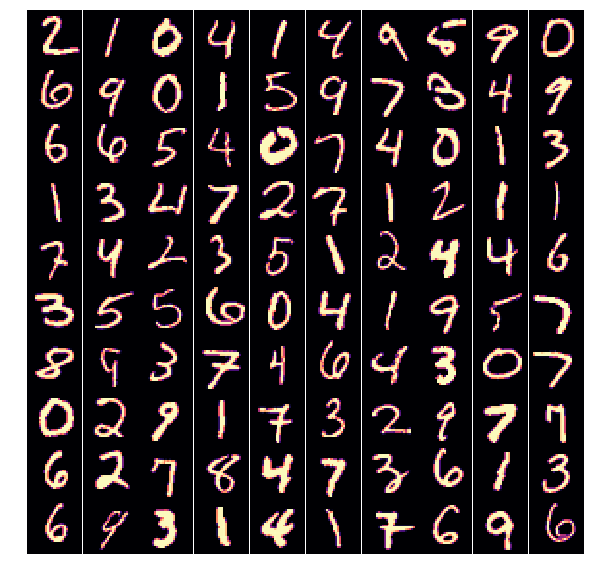

initializing Neural Network Parameters.....
initial theta1: 
 [[-0.17196079  0.41616419 -0.07839022 ...  0.06820306 -0.0701618
  -0.10882373]
 [ 0.3775114  -0.09992138 -0.11723144 ... -0.15383367 -0.18514893
  -0.37232869]
 [-0.11688146  0.01383009  0.36922718 ...  0.3674348   0.25756018
  -0.07676362]
 ...
 [-0.25679415  0.44632173  0.26776834 ... -0.0544201   0.06635981
   0.44472649]
 [ 0.34630681  0.12081602 -0.47034991 ... -0.26865922  0.09791835
  -0.13739969]
 [ 0.47028326  0.43248275 -0.31594275 ... -0.07315404 -0.34369963
   0.18861002]]


In [32]:
### Load and check the shape of the dataset, also add bias column

# Load training dataset
X, y = fin.data_in('train')
m, n = X.shape #(6000, 784), m for number of training examples, n for number of features
print('X: ', X.shape)
print('y: ', y.shape)
# Adding bias terms to X, training dataset 
X = np.c_[np.ones((m, 1)), X] ## adding bias term to X

# Load testing dataset
Xt, yt = fin.data_in('test')
mt, nt = Xt.shape
Xt = np.c_[np.ones((mt, 1)), Xt] 
print("X_test: ", Xt.shape)
print("y_test: ", yt.shape)

# Plot some data
visualize(10, 10, Xt[:100, 1:])

### Set up the neural net architectures
input_layer_size = 784 # 28x28 input images of digits
hidden_layer_size = 784 # hidden units
num_labels = 10 # classify into 10 outputs, same as number of output layer's units

### setting cloths name labels for # labels for human interpretation
human_label = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'} 

### Weight Initialization
eps = 0.5
print('initializing Neural Network Parameters.....')

## initializing random values of theta here
r_theta1 = np.random.random((hidden_layer_size, n+1))*2*eps-eps
r_theta2 = np.random.random((num_labels, hidden_layer_size+1))*2*eps-eps
print('initial theta1: \n', r_theta1)

## "flattening" the theta matrices, so it can be fed to optimization algorithm
r_nn_params = np.concatenate((r_theta1.reshape(r_theta1.size, order='F'), r_theta2.reshape(r_theta2.size, order='F')))

## 3. Training!

- mymethod: optimization algorithm of your choice. For details and example [Scipy.optimize](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)
- maxiter: maximum number of training iteration
- lam: lambda value for regularization (weight decay)

In [37]:
# Setup
mymethod = 'L-BFGS-B' # specifying the optimization algorithm
maxiter = 30
lam =0.9 
j_hist = [] # recording history of cost over the training
test_acc = []
print('training NN by {} for {} iteration...'.format(mymethod, maxiter))

# Now train
## arguments for the optimization algorithm
myargs = (input_layer_size, hidden_layer_size, num_labels, X, y, lam) # args for miminize
results = minimize(CostFunction, x0=r_nn_params, args=myargs, options={'disp': True, 'maxiter':maxiter}, method=mymethod, jac=True)
nn_params = results['x']


print("training done!")

training NN by L-BFGS-B for 30 iteration...
training done!


### Prediction and Model Evaluation

Here we'll evaluate the model, with training and testing accuracy metrics, and visualize cost over number of iterations.

Training set accuracy: 
 92.2665377756296 %
done prediction, now calculate acc...


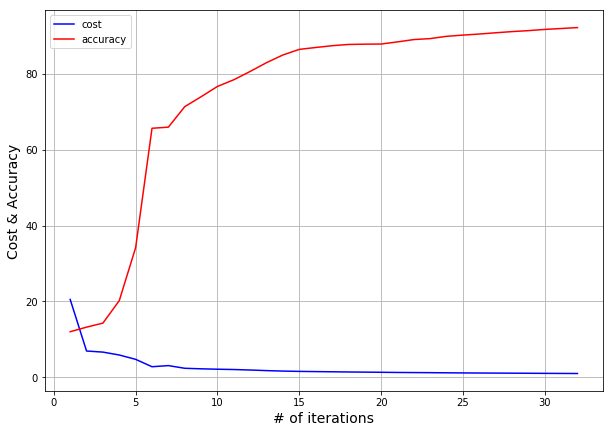

In [80]:
# flattening the theta matrics
theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                         (hidden_layer_size, input_layer_size + 1), order='F')
theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                         (num_labels, hidden_layer_size + 1), order='F')


### Training set Prediction ###
prediction = predict(theta1, theta2, X)
accuracy = (prediction == y).astype(float).mean()*100

print('Training set accuracy: \n', accuracy, '%')

### Testing set Prediction ###
prediction_test = predict(theta1, theta2, Xt)
print("done prediction, now calculate acc...")
accuracy_test = (prediction_test == yt).astype(float).mean()*100

## Now plot the cost function vs iteration
plt.figure(figsize=(10, 7))
axis_font = {'size': 14, 'color':'black'}
plt.plot(np.arange(1, len(j_hist)+1), j_hist, 'b', label='cost')
plt.plot(np.arange(1, len(test_acc)+1), test_acc, 'r', label='accuracy')
plt.legend()
plt.xlabel('# of iterations', fontdict=axis_font)
plt.ylabel('Cost & Accuracy', fontdict=axis_font)
plt.grid(True)
plt.show()

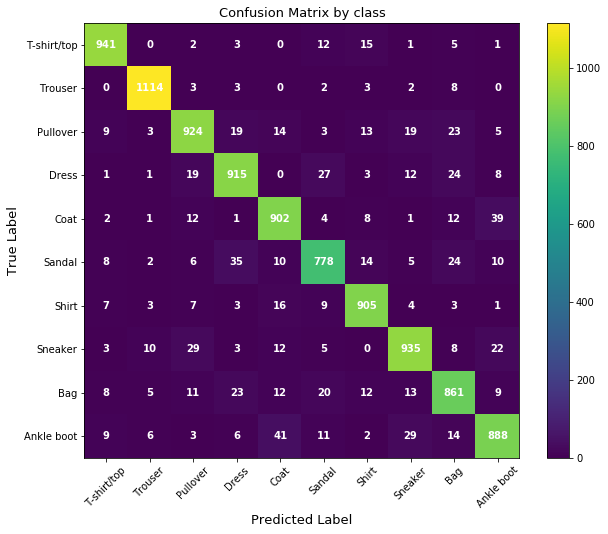

In [78]:
## Now, let's plot a confusion matrix using sklearn for more detailed analysis
cm = confusion_matrix(yt, prediction_test)
fig = plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest')
plt.colorbar()
axis_font = {'size': 13, 'color':'black'}
classNames = [human_label[i] for i in range(10)]
plt.title("Confusion Matrix by class", fontdict=axis_font)
plt.ylabel("True Label", fontdict=axis_font)
plt.xlabel("Predicted Label", fontdict=axis_font)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
fdic = {'size':10, 'color':'white', 'weight':'heavy'}
for i in range(10):
    for j in range(10):
        plt.text(j, i, str(cm[i, j]), fontdict=fdic, horizontalalignment='center',verticalalignment='center')
plt.show()